# Training a Cursive Transformer
Sam Greydanus | 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
import os, sys, time, math, argparse, io, copy, json
from dataclasses import dataclass
from typing import List

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


In [2]:
def load_and_parse_data():
    uploaded = files.upload()
    file_content = next(iter(uploaded.values()))
    data = json.loads(file_content.decode('utf-8'))
    for i in range(len(data)):
      data[i]['points'] = np.array(data[i]['points'])
    return data

def plot_strokes(stroke, title, fig=None, ax=None):
    """Plot a single stroke"""
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(12, 2))

    # Separate strokes based on pen lifts
    strokes = []
    current_stroke = []
    for point in stroke:
        if point[2] == 1:  # Pen is down
            current_stroke.append(point)
        else:  # Pen is up
            if current_stroke:
                strokes.append(current_stroke)
                current_stroke = []
    if current_stroke:
        strokes.append(current_stroke)

    # Plot each stroke
    for stroke in strokes:
        x, y = zip(*[(p[0], 1 - p[1]) for p in stroke])  # Invert y-axis
        ax.plot(x, y, 'b-')

    ax.set_aspect('equal') ; ax.set_title(title)

    if fig is None:
        plt.show()

    return fig, ax


def decompose_offsets(offsets, eps=1e-8):
    magnitudes = np.linalg.norm(offsets[:, :2], axis=1, keepdims=True)  # Calculate magnitudes of vectors
    unit_vectors = np.where(magnitudes == 0, np.zeros_like(offsets[:, :2]), offsets[:, :2] / (eps+magnitudes))  # Avoid division by zero
    new_format = np.hstack((unit_vectors, magnitudes, offsets[:, 2:3]))  # Concatenate unit vectors, magnitudes and pen_down flags
    return new_format

def reconstruct_offsets(decomposed_data):
    unit_vectors = decomposed_data[:, :2]
    magnitudes = decomposed_data[:, 2:3]
    pen_down = decomposed_data[:, 3:4]
    reconstructed_offsets = unit_vectors * magnitudes  # Multiply unit vector components by magnitudes
    reconstructed_data = np.hstack((reconstructed_offsets, pen_down))  # Concatenate the reconstructed offsets with pen_down flags
    return reconstructed_data


def preprocess_stroke_data(entry):
    points = entry['points']
    aspect_ratio = entry['metadata']['aspectRatio']
    points[:, 0] *= aspect_ratio  # Scale x by aspect ratio
    points[:, 0] -= points[0, 0]

    # Calculate differences (dx, dy), not considering pen_down
    offsets = np.zeros_like(points)
    offsets[1:, 0:2] = np.diff(points[:, 0:2], axis=0)  # Compute dx, dy
    offsets[:, 2] = points[:, 2]  # Copy pen_down directly

    # Decouple direction from magnitude (this will help with tokenization)
    offsets_dec = decompose_offsets(offsets)
    return offsets_dec

def offsets_to_strokes(offsets_dec):
    # Calculate cumulative sums to get absolute positions
    offsets = reconstruct_offsets(offsets_dec)

    absolute_coords = np.cumsum(offsets[:, :2], axis=0)
    stroke_data = np.hstack((absolute_coords, offsets[:, 2:3]))
    return stroke_data

In [3]:
raw_json = load_and_parse_data()

Saving dataset.json to dataset.json


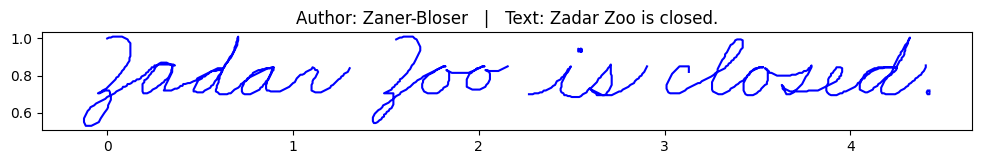

In [4]:
# entry = copy.deepcopy(raw_json[1])
examples = [preprocess_stroke_data(entry) for entry in copy.deepcopy(raw_json)]
metadatas = [entry['metadata'] for entry in raw_json]

example_ix = 1
reconstructed_points = offsets_to_strokes(examples[example_ix])
metadata = metadatas[example_ix]

title = f"Author: {metadata['author']}   |   Text: {metadata['asciiSequence']}"
_ = plot_strokes(reconstructed_points, title)

In [5]:
print(examples[1][:15])

[[ 0.          0.          0.          1.        ]
 [ 0.89791993 -0.44015683  0.01135958  1.        ]
 [ 0.99999896  0.          0.0096      1.        ]
 [ 0.89791993 -0.44015683  0.01135958  1.        ]
 [ 0.99999902  0.          0.0102      1.        ]
 [ 0.99999896  0.          0.0096      1.        ]
 [ 0.99999902  0.          0.0102      1.        ]
 [ 0.99999902  0.          0.0102      1.        ]
 [ 0.99999896  0.          0.0096      1.        ]
 [ 0.89791993  0.44015683  0.01135958  1.        ]
 [ 0.89791993  0.44015683  0.01135958  1.        ]
 [ 0.88691326  0.46193399  0.01082405  1.        ]
 [ 0.4751485   0.87990462  0.01136486  1.        ]
 [ 0.69253133  0.7213868   0.01386218  1.        ]
 [ 0.          0.999999    0.01        1.        ]]


## Construct a custom stroke tokenizer

In [15]:
class StrokeDataset(Dataset):
    def __init__(self, strokes, texts, chars, max_seq_length=None, max_text_length=None, name=''):
        self.name = name
        self.strokes = strokes  # List of Nx4 arrays, each representing a cursive sentence
        self.texts = texts  # List of corresponding text strings
        self.chars = chars  # String of all possible characters

        self.dx_bins = np.linspace(-1, 1, 81)  # 200 bins
        self.dy_bins = np.linspace(-1, 1, 81)  # 200 bins

        # Modify mag_bins to incorporate pen_down information
        mag_bins_pen_down = np.concatenate([
            np.asarray([0]),
            np.linspace(0.005, 0.015, 11),  # Close around 0.01, 30 bins
            np.geomspace(0.015, 5, 51)[:-1]  # 150 exponential bins
        ])
        mag_bins_pen_up = mag_bins_pen_down + max(mag_bins_pen_down) + 1  # Offset for pen-up states
        self.mag_bins = np.concatenate([mag_bins_pen_down, mag_bins_pen_up])

        self.feature_sizes = [len(self.dx_bins), len(self.dy_bins), len(self.mag_bins)]
        self.cumulative_sizes = np.cumsum([0] + self.feature_sizes)

        # Add special tokens for strokes
        self.PAD_TOKEN = sum(self.feature_sizes)
        self.END_TOKEN = sum(self.feature_sizes) + 1

        # Character tokenization
        self.stoi = {ch:i+1 for i,ch in enumerate(chars)}
        self.itos = {i:s for s,i in self.stoi.items()}
        self.char_PAD_TOKEN = 0

        if max_seq_length is None:
            self.max_seq_length = max(len(stroke) for stroke in strokes) * 3 + 1  # *3 for unraveling, +1 for END token
        else:
            self.max_seq_length = max_seq_length

        if max_text_length is None:
            self.max_text_length = max(len(text) for text in texts)
        else:
            self.max_text_length = max_text_length

    def __len__(self):
        return len(self.strokes)

    def get_vocab_size(self):
        return sum(self.feature_sizes) + 2  # +2 for PAD and END tokens

    def get_char_vocab_size(self):
        return len(self.chars) + 1  # +1 for PAD token

    def get_output_length(self):
        return self.max_seq_length

    def encode_stroke(self, stroke):
        dx_idx = np.digitize(stroke[:, 0], self.dx_bins) - 1
        dy_idx = np.digitize(stroke[:, 1], self.dy_bins) - 1

        # Encode magnitude and pen state together
        mag_idx = np.digitize(stroke[:, 2], self.mag_bins[:len(self.mag_bins)//2]) - 1
        mag_idx[stroke[:, 3] == 0] += len(self.mag_bins) // 2  # Offset for pen-up states

        encoded = np.column_stack([
            dx_idx + self.cumulative_sizes[0],
            dy_idx + self.cumulative_sizes[1],
            mag_idx + self.cumulative_sizes[2]
        ])
        return encoded.flatten()

    def decode_stroke(self, ix):
        if isinstance(ix, torch.Tensor):
            ix = ix.cpu().numpy()

        # Remove PAD and END tokens
        ix = ix[(ix != self.PAD_TOKEN) & (ix != self.END_TOKEN)]

        # Reshape the flattened array back to Nx3
        ix = ix[:(len(ix)//3)*3]
        ix = ix.reshape(-1, 3)

        dx = self.dx_bins[(ix[:, 0] - self.cumulative_sizes[0]).clip(0, len(self.dx_bins)-1)]
        dy = self.dy_bins[(ix[:, 1] - self.cumulative_sizes[1]).clip(0, len(self.dy_bins)-1)]

        mag_idx = ix[:, 2] - self.cumulative_sizes[2]
        pen = (mag_idx < len(self.mag_bins) // 2).astype(int)
        mag_idx[pen == 0] -= len(self.mag_bins) // 2
        mag = self.mag_bins[:len(self.mag_bins)//2][mag_idx.clip(0, len(self.mag_bins)//2 - 1)]

        return np.column_stack([dx, dy, mag, pen])

    def encode_text(self, text):
        return torch.tensor([self.stoi.get(ch, self.char_PAD_TOKEN) for ch in text], dtype=torch.long)

    def decode_text(self, ix):
        if isinstance(ix, torch.Tensor):
            ix = ix.cpu().numpy()
        return ''.join([self.itos.get(i, '') for i in ix if i != self.char_PAD_TOKEN])

    def __getitem__(self, idx):
        stroke = self.strokes[idx]
        text = self.texts[idx]

        # Encode stroke
        encoded_stroke = self.encode_stroke(stroke)
        x = torch.full((self.max_seq_length,), self.PAD_TOKEN, dtype=torch.long)
        y = torch.full((self.max_seq_length,), self.PAD_TOKEN, dtype=torch.long)

        seq_len = min(len(encoded_stroke), self.max_seq_length - 1)  # -1 to leave room for END token
        x[:seq_len] = torch.tensor(encoded_stroke[:seq_len], dtype=torch.long)
        x[seq_len] = self.END_TOKEN

        y[:seq_len] = x[1:seq_len+1]
        y[seq_len] = self.END_TOKEN

        # Encode text (context)
        encoded_text = self.encode_text(text)
        c = torch.full((self.max_text_length,), self.char_PAD_TOKEN, dtype=torch.long)
        text_len = min(len(encoded_text), self.max_text_length)
        c[:text_len] = encoded_text[:text_len]

        return x, c, y

In [16]:
strokes = [preprocess_stroke_data(entry) for entry in copy.deepcopy(raw_json)]
texts = [entry['metadata']['asciiSequence'] for entry in raw_json]
chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,!?- "
dataset = StrokeDataset(strokes, texts, chars)

x, c, y = dataset[1]
decoded_stroke = dataset.decode_stroke(x)
decoded_text = dataset.decode_text(c)

print("Original stroke shape:", examples[1].shape)
print("Encoded stroke shape:", x.shape)
print("Encoded text shape:", c.shape)
print("Decoded stroke shape:", decoded_stroke.shape)

print("\nOriginal stroke (first 5 rows):")
print(examples[1][:5])
print("\nEncoded strokes (first 15 elements):")
print([v.item() for v in x[:15]])
print("\nEncoded text (first 10 elements):")
print(c[:10])
print("\nDecoded stroke (first 5 rows):")
print(decoded_stroke[:5])
print("\nDecoded text:")
print(decoded_text)

Original stroke shape: (1269, 4)
Encoded stroke shape: torch.Size([4654])
Encoded text shape: torch.Size([23])
Decoded stroke shape: (1269, 4)

Original stroke (first 5 rows):
[[ 0.          0.          0.          1.        ]
 [ 0.89791993 -0.44015683  0.01135958  1.        ]
 [ 0.99999896  0.          0.0096      1.        ]
 [ 0.89791993 -0.44015683  0.01135958  1.        ]
 [ 0.99999902  0.          0.0102      1.        ]]

Encoded strokes (first 15 elements):
[40, 121, 162, 75, 103, 169, 79, 121, 167, 75, 103, 169, 79, 121, 168]

Encoded text (first 10 elements):
tensor([26, 27, 30, 27, 44, 68, 26, 41, 41, 68])

Decoded stroke (first 5 rows):
[[ 0.     0.     0.     1.   ]
 [ 0.875 -0.45   0.011  1.   ]
 [ 0.975  0.     0.009  1.   ]
 [ 0.875 -0.45   0.011  1.   ]
 [ 0.975  0.     0.01   1.   ]]

Decoded text:
Zadar Zoo is closed.


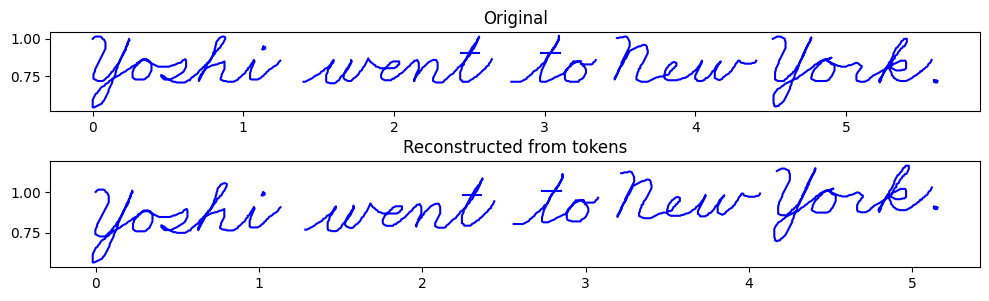

In [17]:
example_ix = 2

strokes = [preprocess_stroke_data(entry) for entry in copy.deepcopy(raw_json)]
texts = [entry['metadata']['asciiSequence'] for entry in raw_json]
chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,!?- "
dataset = StrokeDataset(strokes, texts, chars)

tokenized_offsets, _, _ = dataset[example_ix]  # Get tokenized version of the second example

decimal_offsets = dataset.decode_stroke(tokenized_offsets)
original_points = offsets_to_strokes(examples[example_ix])

reconstructed_points = offsets_to_strokes(decimal_offsets)
metadata = metadatas[example_ix]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3))
plot_strokes(original_points, title='Original', fig=fig, ax=ax1)
plot_strokes(reconstructed_points, title='Reconstructed from tokens', fig=fig, ax=ax2)
plt.tight_layout() ; plt.show()

## Construct the dataset

In [42]:
def create_datasets(max_seq_length=900):
  raw_json = load_and_parse_data()

  stroke_seqs = [preprocess_stroke_data(entry) for entry in copy.deepcopy(raw_json)]
  texts = [entry['metadata']['asciiSequence'] for entry in raw_json]
  chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,!?- "

  max_seq_length = min(max_seq_length, max([len(s)*3 for s in stroke_seqs]))
  print(f"Number of examples in the dataset: {len(stroke_seqs)}")
  print(f"Max token sequence length: {max_seq_length}")
  print(f"Number of unique tokens in the stroke vocabulary: it's complicated")
  print(f"Number of unique characters in the ascii vocabulary: {len(chars)}")
  print("Ascii vocabulary:")
  print(f'\t"{chars}"')

  # partition the input data into a training and the test set
  test_set_size = min(1000, int(len(stroke_seqs) * 0.25)) # 25% of the training set, or up to 1000 examples
  rp = torch.randperm(len(stroke_seqs)).tolist()

  train_stroke_seqs = [stroke_seqs[i] for i in rp[:-test_set_size]]
  train_texts = [texts[i] for i in rp[:-test_set_size]]

  test_stroke_seqs = [stroke_seqs[i] for i in rp[-test_set_size:]]
  test_texts = [texts[i] for i in rp[-test_set_size:]]
  print(f"Split up the dataset into {len(train_stroke_seqs)} training examples and {len(test_stroke_seqs)} test examples")

  # wrap in dataset objects
  train_dataset = StrokeDataset(train_stroke_seqs, train_texts, chars, max_seq_length, name='train')
  test_dataset = StrokeDataset(test_stroke_seqs, test_texts, chars, max_seq_length, name='test')
  return train_dataset, test_dataset


class InfiniteDataLoader:
    """
    this is really hacky and I'm not proud of it, but there doesn't seem to be
    a better way in PyTorch to just create an infinite dataloader?
    """

    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


train_dataset, test_dataset = create_datasets()

Saving dataset.json to dataset (3).json
Number of examples in the dataset: 9
Max token sequence length: 900
Number of unique tokens in the stroke vocabulary: it's complicated
Number of unique characters in the ascii vocabulary: 68
Ascii vocabulary:
	"ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,!?- "
Split up the dataset into 7 training examples and 2 test examples


In [43]:
@torch.no_grad()
def generate(model, idx, context, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
    """
    block_size = model.get_block_size()
    for i in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        # forward the model to get the logits for the index in the sequence
        logits, _ = model(idx_cond)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # either sample from the distribution or take the most likely element
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

@torch.inference_mode()
def evaluate(model, dataset, batch_size=50, max_batches=None):
    model.eval()
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        batch = [t.to(args.device) for t in batch]
        X, C, Y = batch
        logits, loss = model(X, Y)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss

def save_samples(model, dataset, num=2, model_device='cpu', debug=False, warmup_steps=100):
    """ samples from the model and plots the decoded strokes """
    if debug:
      print('Switch from model_device to model.device someday...')
    else:
      model_device = list(model.parameters())[0].device # hacky

    stroke_seq, context, _ = dataset[0]
    X_init = torch.stack([stroke_seq[:warmup_steps]]*num).to(model_device) #torch.zeros(num, 1, dtype=torch.long).to(model_device)
    context = context.long().to(model_device)
    context = torch.stack([context]*num)
    top_k = None  # You can adjust this if needed
    steps = 600 #dataset.get_output_length() - 1  # -1 because we already start with the first token

    if debug:
      X_samp = torch.stack([stroke_seq]*num) # temporary hack
    else:
      X_samp = generate(model, X_init, context, steps, top_k=top_k, do_sample=True).to('cpu')

    for i in range(X_samp.size(0)):
        # get the i'th row of sampled integers, as python list
        row = X_samp[i].detach().cpu().numpy()
        offset_samp = dataset.decode_stroke(row)
        point_samp = offsets_to_strokes(offset_samp)
        decoded_ascii = dataset.decode_text(context[i])

        # Plot the stroke
        fig, ax = plot_strokes(point_samp, f'Sample {i+1}: "{decoded_ascii}"')
        #plt.axis('off')
        fig.savefig(f"{dataset.name}_sample_{i+1}.png")
        plt.close(fig)
        print(f"Saved {dataset.name}_sample_{i+1}.png")

    print('-'*80)

In [45]:
# save_samples(model, train_dataset)

# plt.figure(dpi=200)
# img = mpimg.imread('train_sample_1.png')
# plt.imshow(img) ; plt.axis('off') ; plt.show()

In [46]:
# x, c, y = train_dataset[0]
# x[:5], y[:5]

## Initialize the model

In [47]:
# -----------------------------------------------------------------------------
# Transformer Language Model (*exactly* as used in GPT-2)

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.c_proj(m.act(m.c_fc(x))) # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class Transformer(nn.Module):
    """ Transformer Language Model, exactly as seen in GPT-2 """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("Number of Transformer parameters: {:.0f}".format(n_params,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

@dataclass
class ModelConfig:
    block_size: int = None # length of the input sequences of integers
    vocab_size: int = None # the input integers are in range [0 .. vocab_size -1]
    # parameters below control the sizes of each model slightly differently
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4

In [57]:
@dataclass
class AppConfig:
    # system/input/output
    input_file: str = 'names.txt'
    work_dir: str = 'out'
    resume: bool = False
    sample_only: bool = False
    num_workers: int = 1 # 4
    max_steps: int = -1
    device: str = 'cuda'
    seed: int = 3407

    # sampling
    top_k: int = -1

    # model configuration
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4

    # optimization
    batch_size: int = 10 #32
    learning_rate: float = 1e-3 # 5e-4
    weight_decay: float = 0.01

args = AppConfig()

In [58]:
# system inits
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
os.makedirs(args.work_dir, exist_ok=True)
writer = SummaryWriter(log_dir=args.work_dir)

# init datasets
train_dataset, test_dataset = create_datasets()
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
print(f"Dataset determined that: {vocab_size=}, {block_size=}")

# init model
config = ModelConfig(vocab_size=vocab_size, block_size=block_size,
                    n_layer=args.n_layer, n_head=args.n_head,
                    n_embd=args.n_embd, n_embd2=args.n_embd2)
model = Transformer(config)
model.to(args.device)
print(f"Model #params: {sum(p.numel() for p in model.parameters())}")
if args.resume or args.sample_only: # note: if we sample-only then we also assume we are resuming
    print("resuming from existing model in the workdir")
    model.load_state_dict(torch.load(os.path.join(args.work_dir, 'model.pt')))
if args.sample_only:
    save_samples(num=50)
    sys.exit()

# init optimizer and batch loader
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay, betas=(0.9, 0.99), eps=1e-8)
batch_loader = InfiniteDataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, num_workers=args.num_workers)

Saving dataset.json to dataset (7).json
Number of examples in the dataset: 9
Max token sequence length: 900
Number of unique tokens in the stroke vocabulary: it's complicated
Number of unique characters in the ascii vocabulary: 68
Ascii vocabulary:
	"ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,!?- "
Split up the dataset into 7 training examples and 2 test examples
Dataset determined that: vocab_size=288, block_size=900
Number of Transformer parameters: 276096
Model #params: 294528


## Sample from the untrained model

Saved test_sample_1.png
Saved test_sample_2.png
--------------------------------------------------------------------------------


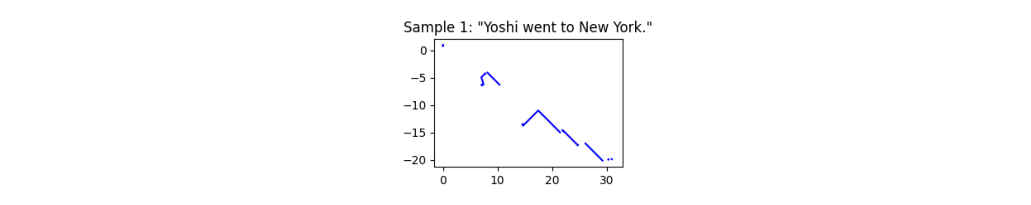

In [59]:
save_samples(model, test_dataset)

plt.figure(dpi=200)
img = mpimg.imread('test_sample_1.png')
plt.imshow(img) ; plt.axis('off') ; plt.show()

## Train the model

In [60]:
# training loop
best_loss = None
step = 0
while True:

    t0 = time.time()

    # get the next batch, ship to device, and unpack it to input and target
    batch = batch_loader.next()
    batch = [t.to(args.device) for t in batch]
    X, C, Y = batch

    # feed into the model
    logits, loss = model(X, Y)

    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # wait for all CUDA work on the GPU to finish then calculate iteration time taken
    if args.device.startswith('cuda'):
        torch.cuda.synchronize()
    t1 = time.time()

    # logging
    if step % 25 == 0:
        print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")

    # evaluate the model
    if step > 0 and step % 500 == 0:
        train_loss = evaluate(model, train_dataset, batch_size=100, max_batches=10)
        test_loss  = evaluate(model, test_dataset,  batch_size=100, max_batches=10)
        writer.add_scalar("Loss/train", train_loss, step)
        writer.add_scalar("Loss/test", test_loss, step)
        writer.flush()
        print(f"step {step} train loss: {train_loss:.4f} test loss: {test_loss:.4f}")
        # save the model to disk if it has improved
        if best_loss is None or test_loss < best_loss:
            out_path = os.path.join(args.work_dir, "model.pt")
            print(f"Test loss {test_loss:.4f} is the best so far, saving model to {out_path}")
            torch.save(model.state_dict(), out_path)
            best_loss = test_loss

    # sample from the model
    if step > 0 and step % 200 == 0:
        save_samples(model, train_dataset, num=4)
        save_samples(model, test_dataset, num=4)

    step += 1
    # termination conditions
    if args.max_steps >= 0 and step >= args.max_steps:
        break

step 0 | loss 5.9230 | step time 103.88ms
step 25 | loss 2.6127 | step time 86.99ms
step 50 | loss 1.4767 | step time 92.77ms
step 75 | loss 1.1740 | step time 86.69ms
step 100 | loss 1.0569 | step time 86.13ms
step 125 | loss 0.9573 | step time 86.15ms
step 150 | loss 0.8163 | step time 86.21ms
step 175 | loss 0.6663 | step time 90.97ms
step 200 | loss 0.4961 | step time 86.80ms
Saved train_sample_1.png
Saved train_sample_2.png
Saved train_sample_3.png
Saved train_sample_4.png
--------------------------------------------------------------------------------
Saved test_sample_1.png
Saved test_sample_2.png
Saved test_sample_3.png
Saved test_sample_4.png
--------------------------------------------------------------------------------
step 225 | loss 0.3253 | step time 86.43ms
step 250 | loss 0.1754 | step time 91.68ms
step 275 | loss 0.1188 | step time 89.00ms
step 300 | loss 0.0599 | step time 86.00ms
step 325 | loss 0.0454 | step time 86.15ms
step 350 | loss 0.0195 | step time 85.45ms
s

KeyboardInterrupt: 

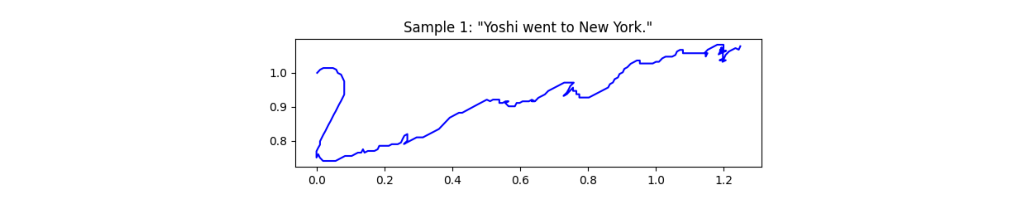

In [71]:
plt.figure(dpi=200)
img = mpimg.imread('test_sample_1.png')
plt.imshow(img) ; plt.axis('off') ; plt.show()